## Open Variable Inspector

In [ ]:
# from google.colab import output

# with output.temporary():
#     !pip install --upgrade git+https://github.com/Kreijstal/colab_inspector.git 
#     !python2.7 -m pip install --upgrade git+https://github.com/blois/colab_inspector.git #yes, really.
#     !jupyter nbextension install --py inspector

# import inspector

# inspector.watch_globals()

## Import Libraries

In [ ]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, f1_score

## Download Files

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate
drive = None
def authenticate():
    global drive
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

#Download files
def downloadFiles(fileIds):
    authenticate()
    for fileId in fileIds:    
        downloaded = drive.CreateFile({"id": fileId[1]})
        downloaded.GetContentFile(fileId[0])


In [ ]:
#Download file if not existing
try:
  _ = open("train.csv", "r")
except:
  downloadFiles([["train.csv", "1XicflnY9xgevybwLTmxNMnmSHl-3vQgy"]])

try:
  _ = open("val.csv", "r")
except:
  downloadFiles([["val.csv", "1rZ8D2snxT9lET6_0uEyhDUgkpNTsoZJn"]])

try:
  _ = open("test_without_labels.csv", "r")
except:
  downloadFiles([["test_without_labels.csv", "1Y_FzoKHwQpfSNIqCjdE-TI0cCC1ul-Lz"]])


In [ ]:
# The proportion of the entired dataset
DATASET_SIZE = 1

# Read dataset from csv
def read_dataset(filename, size_factor=DATASET_SIZE):
    df = pd.read_csv(filename)

    total_row = df.shape[0]
    max_row = int(total_row * size_factor)

    x, y = [], []
    sentences = df['sents'].tolist()[:max_row]
    for sentence in sentences:
        sent = sentence.split(' ')
        x.append(sent)

    if 'labels' in df.columns:
        labels = df['labels'].tolist()[:max_row]
        for label in labels: 
            lab = label.split(' ')
            y.append(lab)
        
    return x, y

# Prepare train, val, test set
x_train, y_train = read_dataset('train.csv')
x_val, y_val = read_dataset('val.csv')
x_test, _ = read_dataset('test_without_labels.csv')

print(f'Total training size: {len(x_train)}\n Sample input: {x_train[1]} \n Sample output: {y_train[1]}')

Total training size: 573
 Sample input: ['The', 'hospital', 'has', 'facilities', 'for', 'MRI', 'and', 'CT', 'scan', ',', 'a', 'gamma', 'camera', 'and', 'lithotripsy', 'device', '.'] 
 Sample output: ['B-Location', 'I-Location', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Embedding

### Word Embedding

In [ ]:
# Pretrained embedding
# From: https://github.com/RaRe-Technologies/gensim-data
import gensim.downloader as api
word_emb_model = api.load("glove-wiki-gigaword-100") 

# Embedding dimension
EMBEDDING_DIM = 100

# Word <--> Index Mapping
word_to_ix = {}
for sentence in x_train+x_val+x_test:
    for word in sentence:
        word = word.lower()
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_list = list(word_to_ix.keys())
ix_to_word = {v:k for k,v in word_to_ix.items()}

# How many unique words
VOCAB_SIZE = len(word_to_ix)

# Addtional Words
START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix = {START_TAG:0, STOP_TAG:1}
for tags in y_train+y_val:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

# Create a Matrix: word -> vector
embedding_matrix = []
for word in word_list:
    try:
        embedding_matrix.append(word_emb_model.wv[word])
    except:
        embedding_matrix.append([0]*EMBEDDING_DIM)
embedding_matrix = np.array(embedding_matrix)
embedding_matrix.shape

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(3957, 100)

In [ ]:
def to_index(data, to_ix, lower=True):
    input_index_list = []
    for sent in data:
        input_index_list.append([to_ix[w.lower() if lower else w] for w in sent])
    return input_index_list

train_input_index =  to_index(x_train,word_to_ix)
train_output_index = to_index(y_train,tag_to_ix, lower=False)
val_input_index = to_index(x_val,word_to_ix)
val_output_index = to_index(y_val,tag_to_ix, lower=False)
test_input_index = to_index(x_test,word_to_ix)

print('Input: ', len(train_input_index[1]))
print('Output: ', len(train_output_index[1]))

Input:  17
Output:  17


### PoS Embedding

In [ ]:
import nltk
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
tagdict = nltk.load('help/tagsets/upenn_tagset.pickle')

tagdict.keys()
# nltk.help.upenn_tagset()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


dict_keys(['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS'])

In [ ]:
# Total number of PoS tags
POSTAG_SIZE = len(list(tagdict.keys()))
postag_list = list(tagdict.keys())

# PoS tag <--> word index
pos_to_ix = { k:v for v, k in enumerate(postag_list) }

# PoS Embedding Matrix
pos_embedding_matrix = np.zeros((VOCAB_SIZE, POSTAG_SIZE))
for word_idx, word in enumerate(word_list):
    tag = pos_tag([word])
    pos_idx = pos_to_ix[tag[0][1]]
    pos_embedding_matrix[word_idx, pos_idx] = 1

print(f'PoS Embedding Matrix: {pos_embedding_matrix.shape}\n{pos_embedding_matrix}')

PoS Embedding Matrix: (3957, 45)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


## Implementation

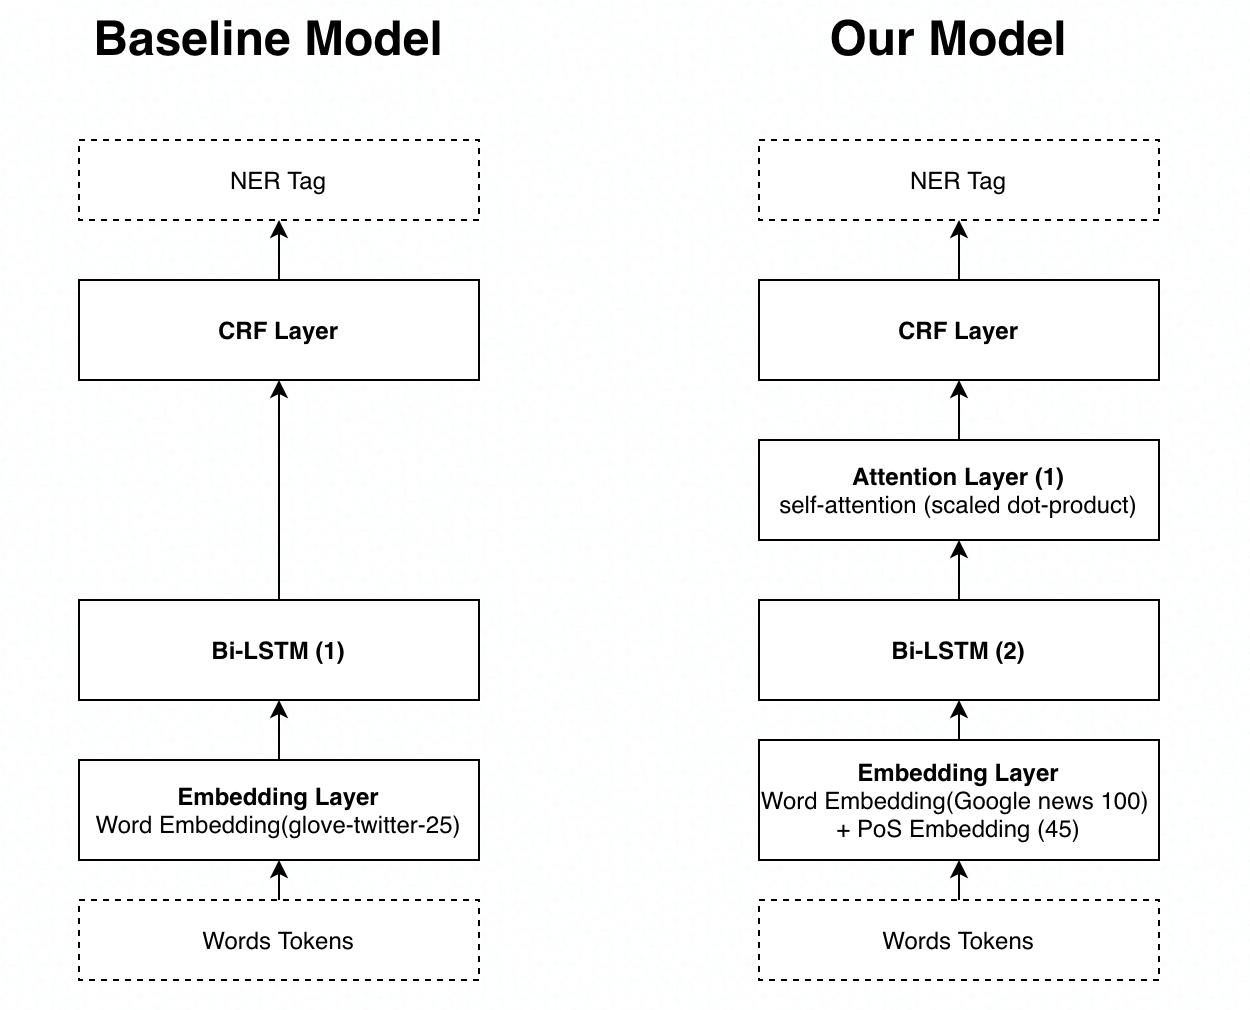

### Hyper parameters

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### CRF Layer

In [ ]:
class CRF_layer(torch.nn.Module):
    '''
    Claim: The CRF_layer Code is derived from PyTorch Tutorial. We wrote a wrapper class for it. 
    More: https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html
    '''
    def __init__(self, tag_to_ix):
        """
        """
        super(CRF_layer, self).__init__()

        self.vocab_size = VOCAB_SIZE
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000
        
    def forward(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(self._log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = self._log_sum_exp(terminal_var)
        return alpha

    def decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = self._argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = self._argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path
        
    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _argmax(self, vec):
        # return the argmax as a python int
        _, idx = torch.max(vec, 1)
        return idx.item()

    # Compute log sum exp in a numerically stable way for the forward algorithm
    def _log_sum_exp(self, vec):
        max_score = vec[0, self._argmax(vec)]
        max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
        return max_score + \
            torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


### Attention Layer

In [ ]:
class Attention_layer(torch.nn.Module):
    def __init__(self, input_size, attention_type='dot', dropout_rate=0.5):
        """
        Define the trainable parameters for attention calculation.
        Inputs:
            inputsize:          input dimension size 
            attention_type:     dot | scaled_dot | cos_sim
        """
        super(Attention_layer, self).__init__()
        self.attention_type = attention_type

        self.K = nn.Linear(input_size, input_size, bias=False)
        self.Q = nn.Linear(input_size, input_size, bias=False)
        self.V = nn.Linear(input_size, input_size, bias=False)

        self.K_dropout = nn.Dropout(p=dropout_rate)
        self.Q_dropout = nn.Dropout(p=dropout_rate)
        self.V_dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        """
        Attention calculation
        For self-attention, the Key, Query and Value all equal to x
        """
        out_key = self.K_dropout(self.K(x))
        out_query = self.Q_dropout(self.Q(x))
        out_value = self.V_dropout(self.V(x))

        # Calculate the score in different ways 
        s = 0
        if self.attention_type == 'dot':
            s = torch.bmm(out_key, out_query.view(x.shape[0], -1, 1))
        elif self.attention_type == 'scaled_dot':
            s = torch.bmm(out_key, out_query.view(x.shape[0], -1, 1)) / torch.sqrt(torch.tensor(x.shape[-1]))
        elif self.attention_type == 'cos_sim':
            s = torch.bmm(out_key, out_query.view(x.shape[0], -1, 1)) / (torch.norm(out_key, p=2) * torch.norm(out_query, p=2))

        # Normalise the score 
        w = F.softmax(s, dim=0)

        # Matmul Score and Value
        y = torch.bmm(w, out_value)

        return y



### Model

In [ ]:
class Model(nn.Module):
    def __init__(self, tag_to_ix, embedding_dim, hidden_dim, hidden_layer, dropout_rate, attention_layer, attention_type):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.tagset_size = len(tag_to_ix)
        self.attention_layer = attention_layer

        # Word Embeddings 
        self.word_embeds = nn.Embedding(VOCAB_SIZE, embedding_dim)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))

        # Pos Embeddings
        self.pos_embeds = nn.Embedding(VOCAB_SIZE, POSTAG_SIZE)
        self.pos_embeds.weight.data.copy_(torch.from_numpy(pos_embedding_matrix))
        self.pos_linear = nn.Linear(POSTAG_SIZE, POSTAG_SIZE)

        # Bi-LSTM Layers
        self.lstm = nn.LSTM(embedding_dim+POSTAG_SIZE, hidden_dim // 2, dropout=dropout_rate,
                            num_layers=hidden_layer, bidirectional=True)

        # Attention Layers
        self.attention_layers = nn.ModuleList()
        for layer in range(attention_layer):
            self.attention_layers.append(Attention_layer(embedding_dim+embedding_dim, attention_type, dropout_rate))

        # CRF Layer 
        self.crf_layer = CRF_layer(tag_to_ix)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

    # Forward pass without CRF layer
    def _forward_pass(self, sentence):
        # Word Embeddings
        word_embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)

        # PoS Tag Embeddings
        pos_embeds = self.pos_embeds(sentence).view(len(sentence), 1, -1)
        pos_embeds = self.pos_linear(pos_embeds)

        # Concated Embeddings
        embeds = torch.cat((word_embeds, pos_embeds), 2)

        # LSTM Layers
        lstm_out, _ = self.lstm(embeds)

        # Attention Calculation
        attention_score = lstm_out
        for layer in self.attention_layers[:-1]:
            attention_score = layer(attention_score)

        att_out = attention_score.view(len(sentence), self.hidden_dim)
        feats = self.hidden2tag(att_out)

        return feats

    # Use where Forward Propogation during training
    def forward_training(self, sentence, tags):
        feats = self._forward_pass(sentence)
        forward_score = self.crf_layer.forward(feats)

        # gold_score = self._score_sentence(feats, tags)
        gold_score = self.crf_layer._score_sentence(feats, tags)

        return forward_score - gold_score

    # Use for inference
    def forward(self, sentence): 
        # Get the emission scores from the BiLSTM
        feats = self._forward_pass(sentence)

        # Find the best path, given the features.
        score, tag_seq = self.crf_layer.decode(feats)
        return score, tag_seq
    

In [ ]:
# Calculate the scores given ground truth and prediction
def cal_acc(model, input_index, output_index):
    ground_truth = []
    predicted = []
    for i,idxs in enumerate(input_index):
        ground_truth += output_index[i]
        score, pred = model(torch.tensor(idxs, dtype=torch.long).to(device))
        predicted += pred
    accuracy = sum(np.array(ground_truth) == np.array(predicted))/len(ground_truth)
    f1 = f1_score(ground_truth, predicted, average='weighted')
    return predicted, ground_truth, accuracy, f1

# Visualise the results by ploting the loss and accuray of training and validation during training 
def visualise_results(log, title='results'):
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle(title)

    # Loss
    plt.subplot(221)
    plt.xlabel('#epoch')
    plt.ylabel('loss')
    plt.plot(log['train_loss'], label='train loss')
    plt.plot(log['val_loss'], label='val loss')
    plt.title('loss during training and val')
    plt.legend()

    # Accuracy on train set
    plt.subplot(222)
    plt.xlabel('#epoch')
    plt.ylabel('acc')
    plt.ylim(0, 1)
    plt.plot(log['train_acc'], marker='.', label='train acc')
    plt.plot(log['val_acc'], marker='.', label='val acc')
    plt.plot(log['train_f1'], color='blue', linestyle='dashed', label='train f1')
    plt.plot(log['val_f1'], color='orange', linestyle='dashed', label='val f1')
    plt.title('acc during training and val')
    plt.legend()

    plt.show()


# Map the tag index to NER tag name
def decode_output(output_list):
    ix_to_tag = {v:k for k,v in tag_to_ix.items()}
    return [ix_to_tag[output] for output in output_list]


# Print out the prediction sample and classification report
def evaluate_model(model):
    # Get the results
    y_pred, y_true, _, _ = cal_acc(model, val_input_index, val_output_index)
    y_true_decode = decode_output(y_true)
    y_pred_decode = decode_output(y_pred)

    print(f'Sample ground truth: {y_true_decode[:20]}')
    print(f'Sample prediction: {y_pred_decode[:20]}')

    print(classification_report(y_true_decode, y_pred_decode, digits=4))


def define_train_evaluate_model(model, num_epoch=10):
    # For recording the training log for visualisation
    log = {
        'train_loss': [],
        'train_acc': [],
        'train_f1': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
    }

    # Training Loop
    for epoch in range(num_epoch):  
        time1 = datetime.datetime.now()
        train_loss = 0

        model.train()
        # Mini-Batch Training
        for i, idxs in enumerate(train_input_index):
            tags_index = train_output_index[i]

            # Clear the gradients
            model.zero_grad()

            # Prepare the input and output data as tensors 
            sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
            targets = torch.tensor(tags_index, dtype=torch.long).to(device)

            # Forward propogation
            loss = model.forward_training(sentence_in, targets)

            # Backward Propogation
            loss.backward()

            # Update the model
            optimizer.step()

            # Accumulate the loss
            train_loss+=loss.item()

        # Evaluate the model on train_set and val_set
        model.eval()
        _, _, train_acc, train_f1 = cal_acc(model,train_input_index,train_output_index)
        _, _, val_acc, val_f1 = cal_acc(model,val_input_index,val_output_index)

        # Evaluate on the validation dataset 
        val_loss = 0
        for i, idxs in enumerate(val_input_index):
            tags_index = val_output_index[i]
            sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
            targets = torch.tensor(tags_index, dtype=torch.long).to(device)
            loss = model.forward_training(sentence_in, targets)
            val_loss+=loss.item()
        time2 = datetime.datetime.now()

        # The log of each epoch
        print("Epoch:%d, Training loss: %.2f, train acc: %.4f, train f1: %.4f, val loss: %.2f, val acc: %.4f, val f1: %.4f, time: %.2fs" \
            %(epoch+1, train_loss, train_acc, train_f1, val_loss, val_acc, val_f1, (time2-time1).total_seconds()))
        # Log the training log of each epoch
        log['train_loss'].append(train_loss)
        log['train_acc'].append(train_acc)
        log['train_f1'].append(val_acc)
        log['val_loss'].append(val_loss)
        log['val_acc'].append(val_acc)
        log['val_f1'].append(val_acc)

    # Visualise the results
    visualise_results(log)

    # Evaluate the model
    evaluate_model(model)

    return model, log

Model Setup: 
Model(
  (word_embeds): Embedding(3957, 100)
  (pos_embeds): Embedding(3957, 45)
  (pos_linear): Linear(in_features=45, out_features=45, bias=True)
  (lstm): LSTM(145, 50, num_layers=2, dropout=0.4, bidirectional=True)
  (attention_layers): ModuleList(
    (0): Attention_layer(
      (K): Linear(in_features=200, out_features=200, bias=False)
      (Q): Linear(in_features=200, out_features=200, bias=False)
      (V): Linear(in_features=200, out_features=200, bias=False)
      (K_dropout): Dropout(p=0.4, inplace=False)
      (Q_dropout): Dropout(p=0.4, inplace=False)
      (V_dropout): Dropout(p=0.4, inplace=False)
    )
  )
  (crf_layer): CRF_layer()
  (hidden2tag): Linear(in_features=100, out_features=23, bias=True)
)

Optimizer Setup: 
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0.0001
)

------ Start Training, Testing, Evaluating Process | Total Epoch: 50 ------
Epoch:1, Training loss: 20566.55, train acc:

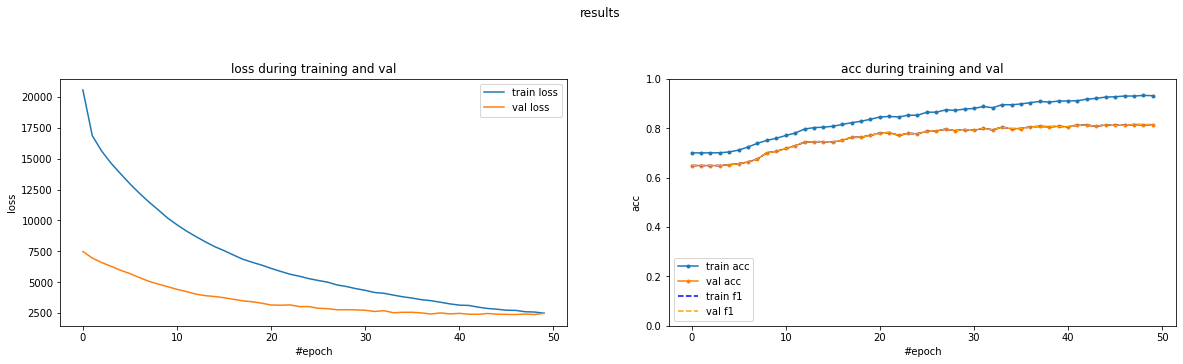

Sample ground truth: ['O', 'B-Quantity', 'I-Quantity', 'I-Quantity', 'I-Quantity', 'I-Quantity', 'B-Person', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Person']
Sample prediction: ['O', 'B-Temporal', 'I-Temporal', 'I-Temporal', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
                     precision    recall  f1-score   support

B-DocumentReference     0.5714    0.2000    0.2963        20
         B-Location     0.6467    0.5806    0.6119       186
 B-MilitaryPlatform     0.0000    0.0000    0.0000        16
            B-Money     0.0000    0.0000    0.0000         5
      B-Nationality     0.0000    0.0000    0.0000         8
     B-Organisation     0.6965    0.6393    0.6667       280
           B-Person     0.8710    0.7941    0.8308       102
         B-Quantity     0.5606    0.6727    0.6116        55
         B-Temporal     0.7619    0.6809    0.7191        47
           B-Weapon     0.1538    0.0526    0.0784        38


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# LSTM
HIDDEN_DIM = 100                # the number of hidden dimension on LSTM
HIDDEN_LAYER = 2                # the number of hidden layer of LSTM

# Attention
ATTENTION_LAYER = 1             # the number of attention layer
ATTENTION_TYPE = 'scaled_dot'   # dot | scaled_dot | cos_sim

# Dropout rate on LSTM layers and Attention units
DROPOUT_RATE = 0.4

# Training
NUM_EPOCH = 50
LR = 0.001
WEIGHT_DECAY = 1e-4

# Create the model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_drop04_25 = Model(tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM, HIDDEN_LAYER, DROPOUT_RATE, ATTENTION_LAYER, ATTENTION_TYPE).to(device)
optimizer = optim.SGD(model_drop04_25.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
print(f'Model Setup: \n{model_drop04_25}\n')
print(f'Optimizer Setup: \n{optimizer}\n')
print(f'------ Start Training, Testing, Evaluating Process | Total Epoch: {NUM_EPOCH} ------')

# Start Training, testing, evaluating process
model_drop04_25, log = define_train_evaluate_model(model_drop04_25,
                         num_epoch=NUM_EPOCH)

In [ ]:
model_drop04_25.eval()
with torch.no_grad():
    predicted = []

    for i,idxs in enumerate(test_input_index):
        score, pred = model_drop04_25(torch.tensor(idxs, dtype=torch.long).to(device))
        predicted += pred
        
test_pred_decode = decode_output(predicted)
id = []
for i,item in enumerate(test_pred_decode):
    id.append(i)

df = pd.DataFrame({'ID':id,'Predicted':test_pred_decode})
df.to_csv(r"result.csv",index=False)

In [ ]:
torch.save(model_drop04_25, 'model_with_dropout04')